To get hourly data from the PVGIS API, you can use the series endpoint, which provides time series data for solar irradiance (DNI, DHI, GHI) and other meteorological parameters.

Required Parameters
- `lat`: Latitude of the location.
- `lon`: Longitude of the location.
- `startyear`: The starting year for the data.
- `endyear`: The ending year for the data.
- `outputformat`: Format of the output (json or csv).
- `usehorizon`: Whether to include horizon shading (1 for yes, 0 for no).
- `pvcalculation`: Set to 0 to get only irradiance data (no PV system calculations).
- `timeformat`: Set to 1 for hourly data.

In [56]:
import pvlib
import matplotlib.pyplot as plt
import pandas as pd

import requests
url = "https://re.jrc.ec.europa.eu/api/seriescalc?"

In order to get the Global Horizonal Irradiance (GHI) data hourly from PV-GIS, I found that I had to set "components" = 0. This first API request therefore gets the data for GHI.

In [ ]:
# Define the API URL and parameters
params = {
    "lat": 51.483,  # Latitude
    "lon": -1.718,  # Longitude
    "startyear": 2005,
    "endyear": 2023,
    "outputformat": "basic",  # Output format (csv or json)
    "usehorizon": 1,        # Include horizon shading
    "pvcalculation": 0,     # Only irradiance data
    "timeformat": 1,        # Hourly data
    "components": 0 ##### NO COMPONENTS: TO GET GHI ######
}

# Make the API request
response = requests.get(url, params=params)
print(response.url)

# Save the response to a CSV file
with open("data/PVGIS_hourly_data_GHI.csv", "w") as file:
    file.write(response.text)

print("Hourly data saved to PVGIS_hourly_data_GHI.csv")

https://re.jrc.ec.europa.eu/api/seriescalc?lat=51.483&lon=-1.718&startyear=2005&endyear=2023&outputformat=basic&usehorizon=1&pvcalculation=0&timeformat=1&components=0
Hourly data saved to PVGIS_hourly_data_GHI.csv


Since I want to manually do the Plane of Array calculations. I will need the Direct Normal Irradiance (DNI) and Diffuse Horizontal Irradiance (DHI) values also.

I was unable to do this with a simple API call, since ticking "components" = 1 gives me the following:

- *Gb(i)*: Beam (direct) irradiance on the inclined plane (plane of the array) (W/m2)
- *Gd(i)*: Diffuse irradiance on the inclined plane (plane of the array) (W/m2)
- *Gr(i)*: Reflected irradiance on the inclined plane (plane of the array) (W/m2)

By setting "trackingtype" = 2 (2-axis tracking), I therefore use the Gb(i) = DNI, since the sun is always directly overhead. The Gd(i) value is the diffuse irradiance on the inclined plane, which I can use to calculate the diffuse fraction. The Gr(i) value is the reflected irradiance on the inclined plane, which I can ignore for now.

In [57]:
params = {
    "lat": 51.483,  # Latitude
    "lon": -1.718,  # Longitude
    "startyear": 2005,
    "endyear": 2023,
    "outputformat": "basic",  # Output format (csv or json)
    "usehorizon": 1,        # Include horizon shading
    "pvcalculation": 0,     # Only irradiance data
    "timeformat": 1,        # Hourly data
    "components": 1,        
    "trackingtype": 2       # 2-axis tracking
}

# Make the API request
response = requests.get(url, params=params)
print(response.url)

# Save the response to a CSV file
with open("data/PVGIS_hourly_data_DNI.csv", "w") as file:
    file.write(response.text)

print("Hourly data saved to PVGIS_hourly_data_DNI.csv")

https://re.jrc.ec.europa.eu/api/seriescalc?lat=51.483&lon=-1.718&startyear=2005&endyear=2023&outputformat=basic&usehorizon=1&pvcalculation=0&timeformat=1&components=1&trackingtype=2
Hourly data saved to PVGIS_hourly_data_DNI.csv


That get's me the DNI I want, and I found this perfectly matched the DNI for the same date and location from the TMY data. However, I still need the Diffuse Horizontal Irradiation. Rather than calculate this from GHI and DNI, I also want to import the data. I therefore also request the components for the Fixed Axis dataset, allowing me to get the Gd(i) Diffuse irradiance on the inclined plane, which at an incline of 0deg is equal to DHI.

In [58]:
# Define the API URL and parameters
params = {
    "lat": 51.483,  # Latitude
    "lon": -1.718,  # Longitude
    "startyear": 2005,
    "endyear": 2023,
    "outputformat": "basic",  # Output format (csv or json)
    "usehorizon": 1,        # Include horizon shading
    "pvcalculation": 0,     # Only irradiance data
    "timeformat": 1,        # Hourly data
    "components": 1 ##### NO COMPONENTS: TO GET GHI ######
}

# Make the API request
response = requests.get(url, params=params)
print(response.url)

# Save the response to a CSV file
with open("data/PVGIS_hourly_data_DHI.csv", "w") as file:
    file.write(response.text)

print("Hourly data saved to PVGIS_hourly_data_DHI.csv")

https://re.jrc.ec.europa.eu/api/seriescalc?lat=51.483&lon=-1.718&startyear=2005&endyear=2023&outputformat=basic&usehorizon=1&pvcalculation=0&timeformat=1&components=1
Hourly data saved to PVGIS_hourly_data_DHI.csv


In [61]:
# Define the file paths
input_file_GHI = 'data/PVGIS_hourly_data_GHI.csv' # No Components; Fixed Axis ---> GHI
input_file_DNI = 'data/PVGIS_hourly_data_DNI.csv' # Radiation Components; 2-Axis Tracker ---> DNI
input_file_DHI = 'data/PVGIS_hourly_data_DHI.csv' # Radiation Components; Fixed Axis ---> DHI

# Read the CSV files, skipping the first two rows and parsing dates
df_GHI = pd.read_csv(input_file_GHI, skiprows=2, parse_dates=True, index_col=0, header=None)
df_GHI.columns = ['G(i)','H_sun','T2m','WS10m','Int']
df_GHI.index = pd.to_datetime(df_GHI.index, format='%Y%m%d:%H%M')

df_DNI = pd.read_csv(input_file_DNI, skiprows=2, parse_dates=True, index_col=0, header=None)
df_DNI.columns = ['Gb(i)','Gd(i)','Gr(i)','H_sun','T2m','WS10m','Int']
df_DNI.index = pd.to_datetime(df_DNI.index, format='%Y%m%d:%H%M')

df_DHI = pd.read_csv(input_file_DHI, skiprows=2, parse_dates=True, index_col=0, header=None)
df_DHI.columns = ['Gb(i)','Gd(i)','Gr(i)','H_sun','T2m','WS10m','Int']
df_DHI.index = pd.to_datetime(df_DHI.index, format='%Y%m%d:%H%M')


# Process the DataFrame to include only the required columns with new names
df_historical = pd.DataFrame({
    'GHI': df_GHI['G(i)'],
    'DNI': df_DNI['Gb(i)'],
    'DHI': df_DHI['Gd(i)'],
    'Temperature': df_GHI['T2m'],
    'Wind Speed': df_GHI['WS10m']
})

df_historical.to_csv('data/PVGIS_hourly_data_historical.csv')
df_historical.head(20)

/var/folders/_m/h8l9pxn15fdf17mc1s6m6cxh0000gn/T/ipykernel_17345/1635892344.py:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_GHI = pd.read_csv(input_file_GHI, skiprows=2, parse_dates=True, index_col=0, header=None)
/var/folders/_m/h8l9pxn15fdf17mc1s6m6cxh0000gn/T/ipykernel_17345/1635892344.py:11: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_DNI = pd.read_csv(input_file_DNI, skiprows=2, parse_dates=True, index_col=0, header=None)
/var/folders/_m/h8l9pxn15fdf17mc1s6m6cxh0000gn/T/ipykernel_17345/1635892344.py:15: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_DHI =

,GHI,DNI,DHI,Temperature,Wind Speed
0,,,,,
2005-01-01 00:10:00,0.0,0.00,0.0,4.29,2.55
2005-01-01 01:10:00,0.0,0.00,0.0,3.98,2.62
2005-01-01 02:10:00,0.0,0.00,0.0,4.16,2.83
2005-01-01 03:10:00,0.0,0.00,0.0,4.51,3.03
2005-01-01 04:10:00,0.0,0.00,0.0,5.21,3.17
2005-01-01 05:10:00,0.0,0.00,0.0,5.94,3.31
2005-01-01 06:10:00,0.0,0.00,0.0,6.59,3.52
2005-01-01 07:10:00,0.0,0.00,0.0,6.73,3.79
2005-01-01 08:10:00,0.0,0.00,0.0,6.97,4.00


In [66]:
# Calculate the GHI from the tracker data and reconcile with the GHI dataset

# make a Location object corresponding to this dataset
location = pvlib.location.Location(latitude=params['lat'],
                                   longitude=params['lon'])

# shift timestamps if necessary from the TMY file to match the solar position calculations
times = df_GHI.index
solar_position = location.get_solarposition(times)

# Calculate the poa for a horizontal panel
poa = pvlib.irradiance.get_total_irradiance(
    surface_tilt=0,  # Tilt angle
    surface_azimuth=180,  # Facing South
    dni=df_historical['DNI'],
    ghi=df_historical['GHI'],
    dhi=df_historical['DHI'],
    solar_zenith=solar_position['apparent_zenith'],
    solar_azimuth=solar_position['azimuth'],
    model='isotropic'
)

display(poa.head(20))
df_poa = pd.DataFrame(poa['poa_global'])

,poa_global,poa_direct,poa_diffuse,poa_sky_diffuse,poa_ground_diffuse
0,,,,,
2005-01-01 00:10:00,0.000000,0.000000,0.0,0.0,0.0
2005-01-01 01:10:00,0.000000,0.000000,0.0,0.0,0.0
2005-01-01 02:10:00,0.000000,0.000000,0.0,0.0,0.0
2005-01-01 03:10:00,0.000000,0.000000,0.0,0.0,0.0
2005-01-01 04:10:00,0.000000,0.000000,0.0,0.0,0.0
2005-01-01 05:10:00,0.000000,0.000000,0.0,0.0,0.0
2005-01-01 06:10:00,0.000000,0.000000,0.0,0.0,0.0
2005-01-01 07:10:00,0.000000,0.000000,0.0,0.0,0.0
2005-01-01 08:10:00,0.000000,0.000000,0.0,0.0,0.0


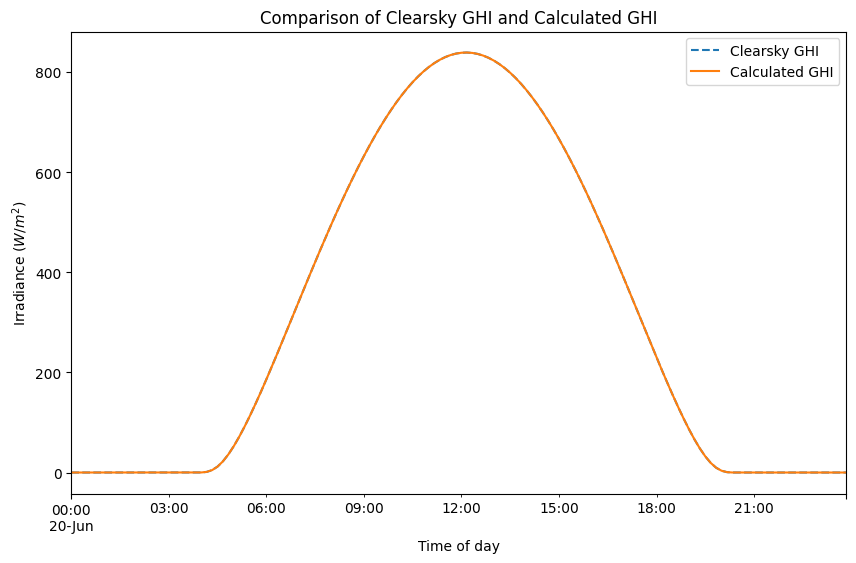

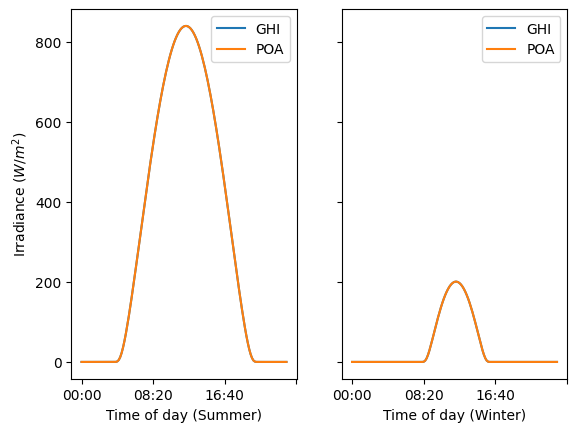

In [67]:
from pvlib import location
from pvlib import irradiance
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

# For this example, we will be using Golden, Colorado
tz = 'UTC'
lat, lon = 51.483, -1.718

# Create location object to store lat, lon, timezone
site = location.Location(lat, lon, tz=tz)


# Calculate clear-sky GHI and transpose to plane of array
# Define a function so that we can re-use the sequence of operations with
# different locations
def get_irradiance(site_location, date, tilt, surface_azimuth):
    # Creates one day's worth of 10 min intervals
    times = pd.date_range(date, freq='10min', periods=6*24,
                          tz=site_location.tz)
    # Generate clearsky data using the Ineichen model, which is the default
    # The get_clearsky method returns a dataframe with values for GHI, DNI,
    # and DHI
    clearsky = site_location.get_clearsky(times)
    # Get solar azimuth and zenith to pass to the transposition function
    solar_position = site_location.get_solarposition(times=times)
    # Use the get_total_irradiance function to transpose the GHI to POA
    POA_irradiance = irradiance.get_total_irradiance(
        surface_tilt=tilt,
        surface_azimuth=surface_azimuth,
        dni=clearsky['dni'],
        ghi=clearsky['ghi'],
        dhi=clearsky['dhi'],
        solar_zenith=solar_position['apparent_zenith'],
        solar_azimuth=solar_position['azimuth'])
    # Return DataFrame with only GHI and POA
    return pd.DataFrame({'GHI': clearsky['ghi'],
                         'POA': POA_irradiance['poa_global']})

def get_irradiance_JH(site_location, date, tilt, surface_azimuth):
    # Creates one day's worth of 10 min intervals
    times = pd.date_range(date, freq='10min', periods=6*24,
                          tz=site_location.tz)
    # Generate clearsky data using the Ineichen model, which is the default
    clearsky = site_location.get_clearsky(times)
    # Get solar azimuth and zenith to pass to the transposition function
    solar_position = site_location.get_solarposition(times=times)
    # Calculate GHI using DNI and DHI with cos(theta_z)
    calculated_ghi = clearsky['dni'] * np.cos(np.radians(solar_position['apparent_zenith'])) + clearsky['dhi']
    # Add the calculated GHI as a new column
    clearsky['calculated_ghi'] = calculated_ghi
    # Return DataFrame with DNI, GHI, DHI, and calculated GHI
    return clearsky[['dni', 'ghi', 'dhi', 'calculated_ghi']]

# Example usage
irradiance_data = get_irradiance_JH(site, '06-20-2020', 30, 0)

# Plot GHI from clearsky vs calculated GHI
plt.figure(figsize=(10, 6))
irradiance_data['ghi'].plot(label='Clearsky GHI', linestyle='--')
irradiance_data['calculated_ghi'].plot(label='Calculated GHI', linestyle='-')
plt.xlabel('Time of day')
plt.ylabel('Irradiance ($W/m^2$)')
plt.title('Comparison of Clearsky GHI and Calculated GHI')
plt.legend()
plt.show()


# Get irradiance data for summer and winter solstice, assuming 25 degree tilt
# and a south facing array
summer_irradiance = get_irradiance(site, '06-20-2020', 0, 0)
winter_irradiance = get_irradiance(site, '12-21-2020', 0, 0)

# Convert Dataframe Indexes to Hour:Minute format to make plotting easier
summer_irradiance.index = summer_irradiance.index.strftime("%H:%M")
winter_irradiance.index = winter_irradiance.index.strftime("%H:%M")

# Plot GHI vs. POA for winter and summer
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
summer_irradiance['GHI'].plot(ax=ax1, label='GHI')
summer_irradiance['POA'].plot(ax=ax1, label='POA')
winter_irradiance['GHI'].plot(ax=ax2, label='GHI')
winter_irradiance['POA'].plot(ax=ax2, label='POA')
ax1.set_xlabel('Time of day (Summer)')
ax2.set_xlabel('Time of day (Winter)')
ax1.set_ylabel('Irradiance ($W/m^2$)')
ax1.legend()
ax2.legend()
plt.show()



{'inputs': {'location': {'latitude': 51.483,
   'longitude': -1.714,
   'elevation': 166.0},
  'meteo_data': {'radiation_db': 'PVGIS-SARAH3',
   'meteo_db': 'ERA5',
   'year_min': 2005,
   'year_max': 2023,
   'use_horizon': True,
   'horizon_db': None,
   'horizon_data': 'DEM-calculated'},
  'plane': {'fixed_horizontal': {'slope': {'value': 0, 'optimal': '-'},
    'azimuth': {'value': '-', 'optimal': '-'}}}},
 'outputs': {'monthly': [{'year': 2005,
    'month': 1,
    'H(h)_m': 22.35,
    'T2m': 5.7},
   {'year': 2005, 'month': 2, 'H(h)_m': 35.0, 'T2m': 3.1},
   {'year': 2005, 'month': 3, 'H(h)_m': 65.18, 'T2m': 6.5},
   {'year': 2005, 'month': 4, 'H(h)_m': 107.24, 'T2m': 8.6},
   {'year': 2005, 'month': 5, 'H(h)_m': 149.06, 'T2m': 10.6},
   {'year': 2005, 'month': 6, 'H(h)_m': 155.9, 'T2m': 15.5},
   {'year': 2005, 'month': 7, 'H(h)_m': 146.17, 'T2m': 16.5},
   {'year': 2005, 'month': 8, 'H(h)_m': 149.43, 'T2m': 15.6},
   {'year': 2005, 'month': 9, 'H(h)_m': 101.28, 'T2m': 14.8},
   

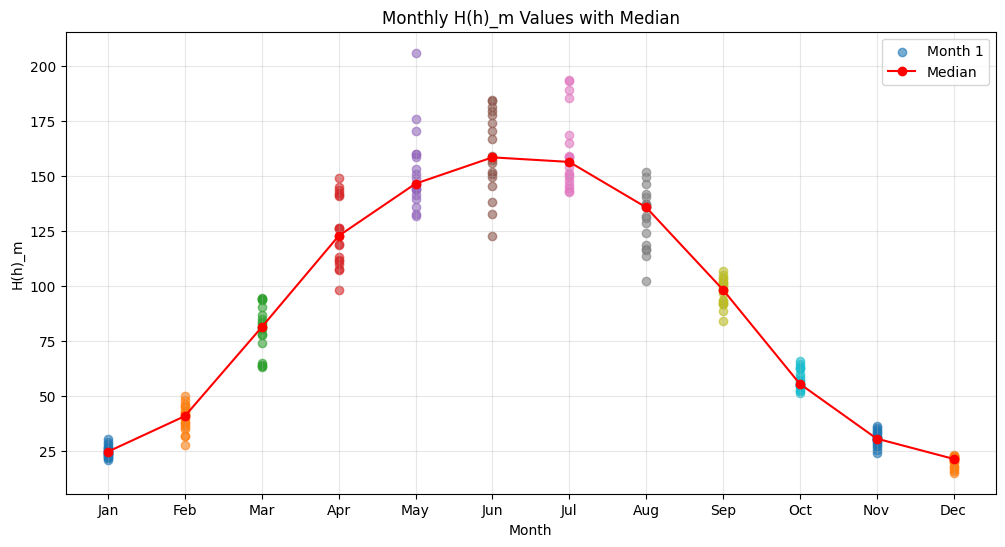

In [68]:
import json
# Open the JSON file and store it as a dictionary
with open('data/Monthlydata_51.483_-1.714_SA3_2005_2023.json', 'r') as file:
    json_data = json.load(file)
    display(json_data)

import pandas as pd
import matplotlib.pyplot as plt

# Extract the 'monthly' data from the JSON
monthly_data = json_data['outputs']['monthly']

# Convert the JSON data into a DataFrame
df = pd.DataFrame(monthly_data)

# Group the data by month
grouped = df.groupby('month')['H(h)_m']

# Plot the data points for each year
plt.figure(figsize=(12, 6))
for month, group in grouped:
    plt.scatter([month] * len(group), group, alpha=0.6, label=f'Month {month}' if month == 1 else "")

# Calculate the median for each month and plot it
median_values = grouped.median()
plt.plot(median_values.index, median_values.values, color='red', marker='o', label='Median')

# Customize the plot
plt.xticks(range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.xlabel('Month')
plt.ylabel('H(h)_m')
plt.title('Monthly H(h)_m Values with Median')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [70]:

pvgis_tmy = pvlib.iotools.get_pvgis_tmy(latitude=51.483, longitude=-1.718, outputformat='json', usehorizon=True, userhorizon=None, startyear=2005, endyear=2023, map_variables=True, url='https://re.jrc.ec.europa.eu/api/', timeout=30, roll_utc_offset=None, coerce_year=None)

In [79]:
data, months_selected, inputs, metadata = pvlib.iotools.get_pvgis_tmy(latitude=51.483, longitude=-1.718, outputformat='json', usehorizon=True, userhorizon=None, startyear=2005, endyear=2023, map_variables=True, url='https://re.jrc.ec.europa.eu/api/', timeout=30, roll_utc_offset=None, coerce_year=None)
data.to_csv('data/PVGIS_tmy_data.csv')

In [78]:
display(data.head(20))
display(inputs)

,temp_air,relative_humidity,ghi,dni,dhi,IR(h),wind_speed,wind_direction,pressure
time(UTC),,,,,,,,,
2018-01-01 00:00:00+00:00,6.00,82.79,0.0,0.00,0.0,296.99,4.79,258.0,97580.0
2018-01-01 01:00:00+00:00,5.71,82.47,0.0,0.00,0.0,292.74,5.04,251.0,97670.0
2018-01-01 02:00:00+00:00,5.41,82.14,0.0,0.00,0.0,288.50,5.28,247.0,97700.0
2018-01-01 03:00:00+00:00,5.12,81.82,0.0,0.00,0.0,284.25,5.53,244.0,97730.0
2018-01-01 04:00:00+00:00,4.83,81.49,0.0,0.00,0.0,280.01,5.77,243.0,97710.0
2018-01-01 05:00:00+00:00,4.53,81.17,0.0,0.00,0.0,275.76,6.02,237.0,97650.0
2018-01-01 06:00:00+00:00,4.24,80.84,0.0,0.00,0.0,271.51,6.26,227.0,97580.0
2018-01-01 07:00:00+00:00,3.94,80.52,0.0,0.00,0.0,267.27,6.51,210.0,97450.0
2018-01-01 08:00:00+00:00,4.12,85.50,0.0,0.00,0.0,275.75,3.31,199.0,97380.0


{'location': {'latitude': 51.483,
  'longitude': -1.718,
  'elevation': 154.0,
  'irradiance_time_offset': 0.1831},
 'meteo_data': {'radiation_db': 'PVGIS-SARAH3',
  'meteo_db': 'ERA5',
  'year_min': 2005,
  'year_max': 2023,
  'use_horizon': True,
  'horizon_db': 'DEM-calculated'}}